In [1]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import math
IOFOLDER='../../DGD_IO/' #<--modify this directory if needed

In [2]:
def val(P,x):
    return P[0]+P[1]*x+P[2]*x*x
def grad(P,x):
    return P[1]+P[2]*2*x

In [3]:
listtonums=lambda A:str(list(A))[1:-1].replace(' ','')
PARSELIST=lambda s:list(map(float,s.split(',')))

In [20]:
def connected(G):
    #check if each vertex can reach every other vertex
    for i in range(len(G)):
        seen=set()
        front=[i]
        seen.add(i)
        while len(front)>0:
            nfront=[]
            for v in front:
                for n in G[v]:
                    if not(n in seen):
                        nfront.append(n)
                        seen.add(n)
            front=nfront
        if len(seen)<len(G):
            return False
    return True

In [54]:
#data generation, using a seeded random number generator
directed=False
Pvals=[i/20 for i in range(1,21)]
print('Pvals='+str(Pvals))
params=[[50,Pvals[(i-1)//100],i] for i in range(1,len(Pvals)*100+1)]
fin=open(IOFOLDER+'input'+('_directed' if directed else '')+'.txt','w')
for param in params:
    N,P,seed=param
    fin.write('N,P,seed={},{},{}\n'.format(N,P,seed))
    rnd.seed(seed)
    att=0
    while True:
        if P=='line':
            graph=[list(range(max(0,i-1),min(N,i+2))) for i in range(N)]
        else:
            graph=[[] for i in range(N)]
            for i in range(N):
                if directed:
                    for j in range(N):
                        if j!=i and rnd.random()<P:
                            graph[i].append(j)
                else:
                    for j in range(i):
                        if rnd.random()<P:
                            graph[i].append(j)
                            graph[j].append(i)
                graph[i].append(i)
        att+=1
        if connected(graph):
            break
    if seed%100==0 or (P==0.05 and seed%1==0):
        print(str(param)+'; # attempts='+str(att))

    #functions
    funcs=[]
    for i in range(N):
        a=rnd.uniform(0,1)
        v=rnd.uniform(-100,100)
        #(ax-v)^2=a^2x^2-2avx+v^2
        funcs.append(np.array([v*v,-2*a*v,a*a]))
    tfunc=np.array([0.0 for i in range(3)])
    for func in funcs:
        tfunc+=func
    tfunc/=N
    optx=-tfunc[1]/(2*tfunc[2])
    optval=val(tfunc,optx)
    #print(str(optx)+','+str(optval))
    locs0=[rnd.uniform(-200,200) for i in range(N)]
    #print('mean starting loc='+str(np.mean(locs0)))
    
    for i in range(N):
        fin.write(str(i)+':'+listtonums(graph[i])+'\n')
    for i in range(N):
        fin.write(str(i)+':'+listtonums(funcs[i])+'\n')
    fin.write(listtonums(locs0)+'\n')

    #graph network visualization
    '''groups=[[] for i in range(N)]
    for i in range(N):
        groups[find(info[1],i)].append(i)
    seq=[]
    for g in groups:
        seq.extend(g)
    locs=[[] for i in range(N)]
    for i in range(N):
        t=2*math.pi*i/N
        locs[seq[i]]=[math.cos(t),math.sin(t)]
    plt.figure()
    amt=0
    for g in groups:
        if len(g)>0:
            amt+=1
    tmp=0
    for g in groups:
        if len(g)>0:
            col=(1-tmp/amt,0,tmp/amt)
            for i in g:
                for j in graph[i]:
                    plt.plot([locs[i][0],locs[j][0]],[locs[i][1],locs[j][1]],linewidth=1,c=col)
            plt.scatter(x=[locs[i][0] for i in g],y=[locs[i][1] for i in g],s=40,c=[col for i in g])
            tmp+=1'''

fin.close()

Pvals=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[50, 0.05, 1]; # attempts=103
[50, 0.05, 2]; # attempts=130
[50, 0.05, 3]; # attempts=28
[50, 0.05, 4]; # attempts=101
[50, 0.05, 5]; # attempts=85
[50, 0.05, 6]; # attempts=125
[50, 0.05, 7]; # attempts=40
[50, 0.05, 8]; # attempts=89
[50, 0.05, 9]; # attempts=63
[50, 0.05, 10]; # attempts=9
[50, 0.05, 11]; # attempts=140
[50, 0.05, 12]; # attempts=3
[50, 0.05, 13]; # attempts=22
[50, 0.05, 14]; # attempts=116
[50, 0.05, 15]; # attempts=74
[50, 0.05, 16]; # attempts=24
[50, 0.05, 17]; # attempts=45
[50, 0.05, 18]; # attempts=57
[50, 0.05, 19]; # attempts=5
[50, 0.05, 20]; # attempts=12
[50, 0.05, 21]; # attempts=95
[50, 0.05, 22]; # attempts=77
[50, 0.05, 23]; # attempts=38
[50, 0.05, 24]; # attempts=52
[50, 0.05, 25]; # attempts=114
[50, 0.05, 26]; # attempts=41
[50, 0.05, 27]; # attempts=44
[50, 0.05, 28]; # attempts=8
[50, 0.05, 29]; # attempts=125
[50, 0.05, 30]; # 

In [4]:
def readrets(file):
    info=open(IOFOLDER+file,'r').read().split('\n')
    A,ITER=list(map(int,info[0].split('=')[1].split(',')))
    data={}
    Tvals=set()
    param=seed=T=optloc=optscr=None
    for i in range(1,len(info)):
        pcs=info[i].split('=')
        if len(pcs)==1:
            continue
        k=pcs[0]
        if k=='N,P,seed':
            split=pcs[1].rindex(',')
            param=pcs[1][:split]
            seed=pcs[1][split+1:]
            if not(param in data):
                data[param]={}
            data[param][seed]={}
        elif k=='T':
            T=pcs[1]
            Tvals.add(T)
            data[param][seed][T]={}
        elif k=='optloc,optscr':
            optloc,optscr=PARSELIST(pcs[1])
            data[param][seed]['optloc']=optloc
            data[param][seed]['optscr']=optscr
        else:
            tmp=PARSELIST(pcs[1][1:-1].replace(' ','')) if pcs[1][0]=='[' else float(pcs[1])
            data[param][seed][T][k]=tmp
    param=seed=T=optloc=optscr=None
    #print(data)
    Tvals=list(reversed(sorted(list(Tvals))))
    return (A,ITER,Tvals,data)

<IPython.core.display.Javascript object>


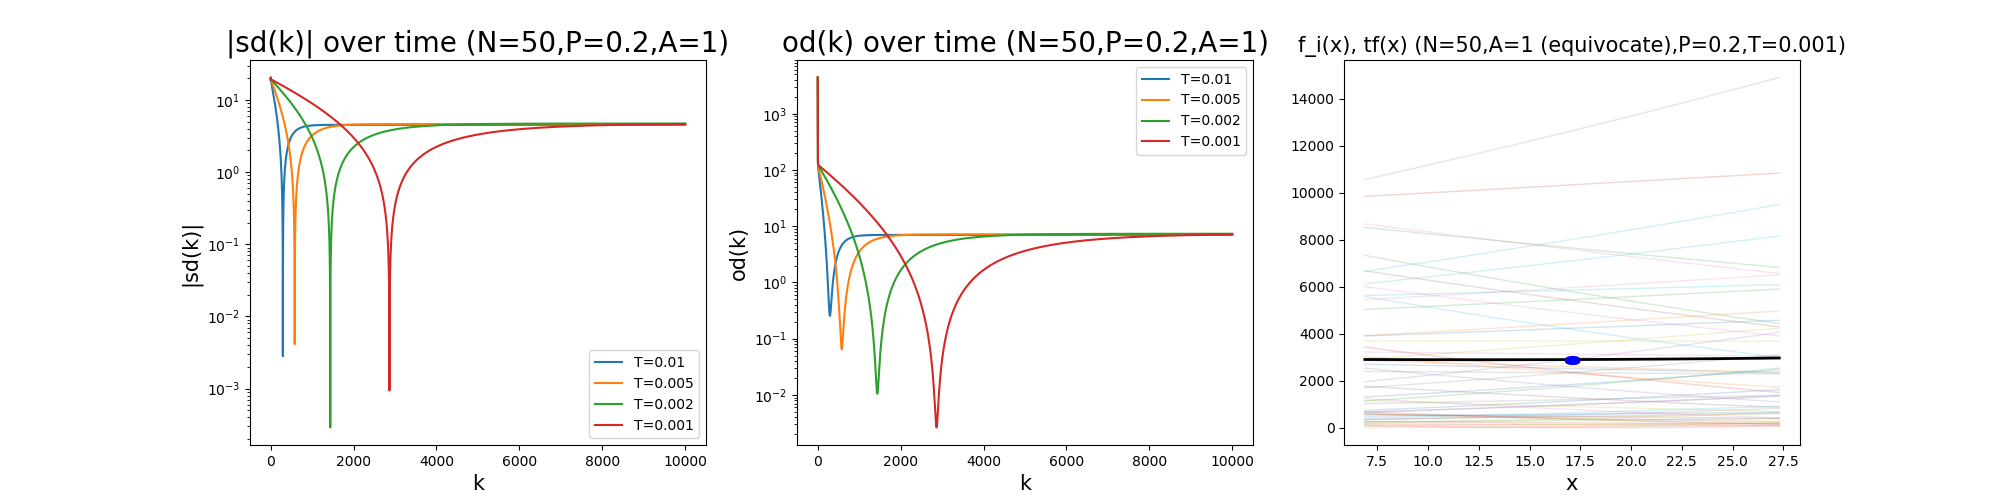

[ 2.93780401e+03 -8.23825799e+00  3.31029061e-01]
optloc=12.443405970949282 optscr=2886.5480206450948
gap=0.05856213948301914


In [366]:
equiv=True
A,ITER,Tvals,data=readrets('stats_out_A=1'+('_equivocate' if equiv else '')+'.txt')
N,P,seed=50,'0.2',1
rdata=data['{},{}'.format(N,P)][str(seed)]
fig,(sold,objd,extra)=plt.subplots(1,3,figsize=(20,5))

title_help=' over time (N={},P={},A={})'.format(N,P,A)
if A==0:
    title_help=' over time (N={},P={})'.format(N,P)
sold.set_title('|sd(k)|'+title_help,fontsize=20)
sold.set_xlabel('k',fontsize=15)
sold.set_ylabel('|sd(k)|',fontsize=15)
sold.set_yscale('log')
for T in Tvals:
    sold.plot(list(map(abs,rdata[T]['msoldiff'])),label='T='+str(T))
sold.legend()

objd.set_title('od(k)'+title_help,fontsize=20)
objd.set_xlabel('k',fontsize=15)
objd.set_ylabel('od(k)',fontsize=15)
objd.set_yscale('log')
for T in Tvals:
    objd.plot(rdata[T]['mobjdiff'],label='T='+str(T))
objd.legend()

extra.set_title('f_i(x), tf(x) (N=50{},P={},T=0.001)'
                .format((',A='+str(A)+(' (equivocate)' if equiv else '')) if A>0 else '',P),fontsize=15)
extra.set_xlabel('x',fontsize=15)
locsfin=rdata['0.001']['locs_fin']
xs=np.linspace(np.min(locsfin)-10,np.max(locsfin)+10,100)
tf=0
for f in funcs:
    tf+=f
tf/=N
print(tf)
print('optloc='+str(-tf[1]/(2*tf[2]))+' optscr='+str(val(tf,(-tf[1]/(2*tf[2])))))
for f in funcs:
    extra.plot(xs,list(map(lambda x:val(f,x),xs)),linewidth=1,alpha=0.2,zorder=1)
extra.plot(xs,list(map(lambda x:val(tf,x),xs)),linewidth=2,c='black',zorder=1)
#extra.set_xlim(-200,200)
#extra.set_ylim(3760,3763)
extra.scatter(locsfin,list(map(lambda x:val(tf,x),locsfin)),s=20,c='blue',zorder=2)
print('gap='+str(rdata['0.001']['locsgap_fin']))
fig.savefig('tmp.png',bbox_inches='tight')

In [7]:
def plotmeans(ax,data,key,func,ylabel,log):
    params=[p for p in data]
    pvals=list(map(lambda p:float(p[p.rindex(',')+1:]),params))
    ax.set_xlabel('P',fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    if log:
        ax.set_yscale('log')
    for T in Tvals:
        ax.plot(pvals,
                list(map(lambda p:np.mean([func(data[p][seed][T][key]) for seed in data[p]]),params)),
                label='T='+str(T))
    ax.legend()

<IPython.core.display.Javascript object>


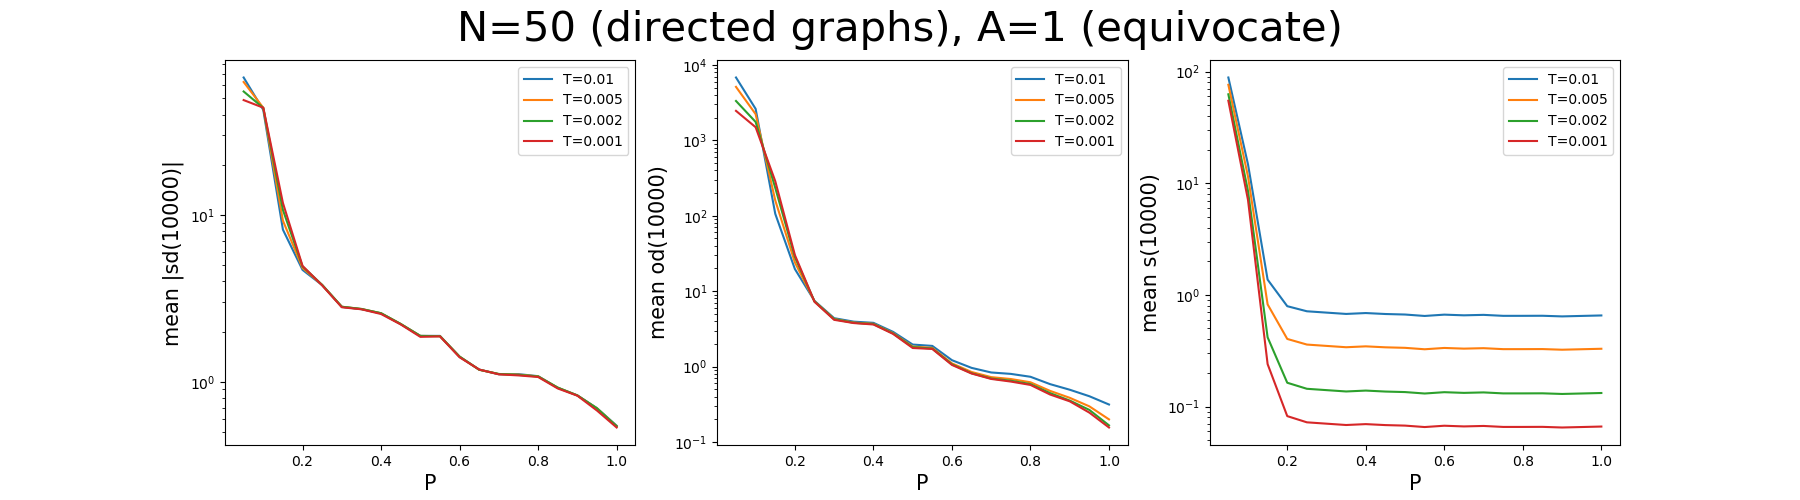

In [21]:
directed=True
equivocate=True
A,ITER,Tvals,data=readrets('out'+('_directed' if directed else '')+'_A=1'+('_equivocate' if equivocate else '')+'.txt')
AXS=3
fig,axs=plt.subplots(1,AXS,figsize=(6*AXS,5))
title=('N=50'+(' (directed graphs)' if directed else '')+', A={}'+(' (equivocate)' if equivocate else '')).format(A)
fig.suptitle(title,fontsize=30)
plotmeans(axs[0],data,'msoldiff_fin',abs,'mean |sd({})|'.format(ITER),True)
plotmeans(axs[1],data,'mobjdiff_fin',lambda x:x,'mean od({})'.format(ITER),True)
plotmeans(axs[2],data,'locs_fin',np.std,'mean s({})'.format(ITER),True)
fig.savefig('tmp.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


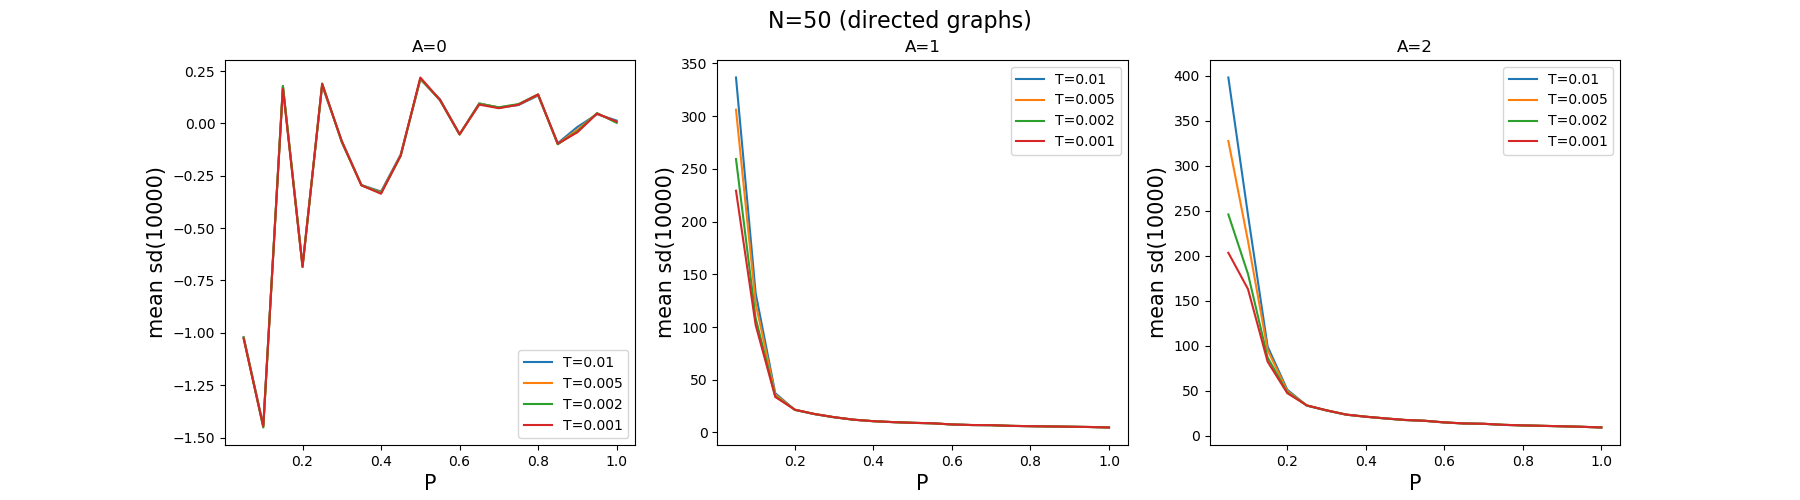

In [17]:
directed=True
AXS=3
fig,axs=plt.subplots(1,AXS,figsize=(6*AXS,5))
title='N=50'+(' (directed graphs)' if directed else '')
fig.suptitle(title,fontsize=16)
for a in range(3):
    A,ITER,Tvals,data=readrets('out'+('_directed' if directed else '')+'_A='+str(a)+'.txt')
    axs[a].set_title('A='+str(a))
    plotmeans(axs[a],data,'msoldiff_fin',lambda x:x,'mean sd({})'.format(ITER),False)
fig.savefig('tmp.png',bbox_inches='tight')